In [1]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ, pulse
from qiskit.tools.monitor import job_monitor
from qiskit.tools.jupyter import *
from qiskit.compiler import assemble

provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy141')
backend = provider.get_backend('ibmq_paris')
backend_defaults = backend.defaults()
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"
calibrations = backend_defaults.instruction_schedule_map
x_schedule = calibrations.get('x',0)

C:\Users\usuario\anaconda3\envs\quantum\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
print(x_schedule)

Schedule((0, Play(Drag(duration=160, amp=(0.2147578819717963+0j), sigma=40, beta=-0.10560341111747902), DriveChannel(0))), name="x")


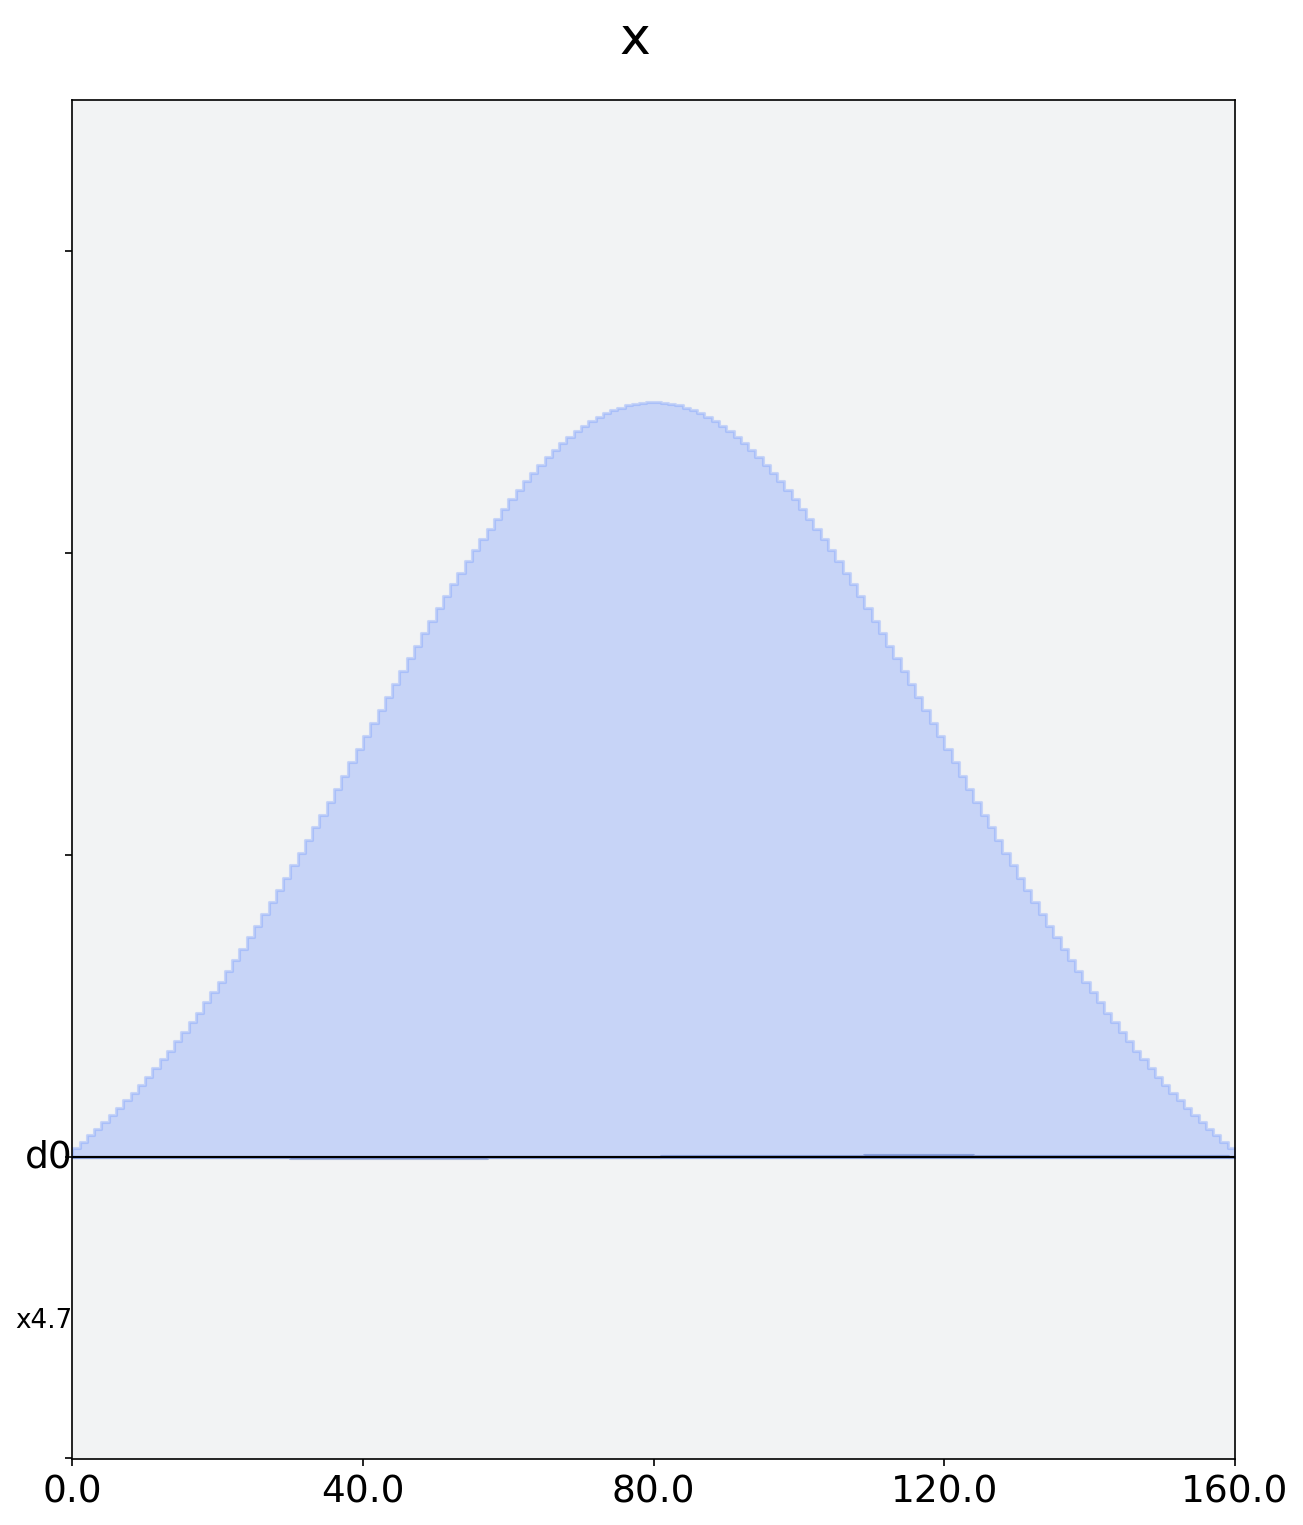

In [3]:
x_schedule.draw()

In [3]:
qubit = 0

meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

center_frequency_Hz = backend_defaults.qubit_freq_est[qubit] 

gnd_schedule = pulse.Schedule(name="ground state")
gnd_schedule += measure

initial_schedule = x_schedule

#current_schedule = 

num_shots_per_schedule = 8192

program = assemble([gnd_schedule, x_schedule],
                                   backend=backend, 
                                   meas_level=1,
                                   meas_return='single',
                                   shots=num_shots_per_schedule,
                                   schedule_los=[{drive_chan: center_frequency_Hz}] * 2)
job = backend.run(program)
job_monitor(job)
result = job.result()

Job Status: job has successfully run


[-17858680. -44896124.j         -19752859. -49177430.4j
 -16703306.2-47603113.59999999j ... -15554099.4-53319341.59999999j
 -15476899.2-49611111.2j        -13321786.8-49393629.59999999j]
[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]
8192
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


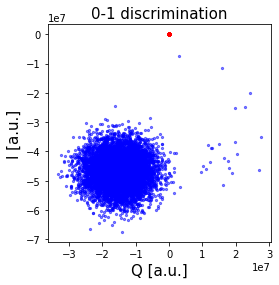

In [8]:
from matplotlib import pyplot as plt
import numpy as np
scale_factor = 0.7
gnd_results = result.get_memory(0)[:, qubit]*scale_factor
final_results = result.get_memory(1)[:, qubit]*scale_factor
for i in range(2):
    print(result.get_memory(i)[:, qubit]*scale_factor)
print(len(gnd_results))
print(final_results[:50])

plt.figure(figsize=[4,4])
# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the final_schedule are plotted in green
plt.scatter(np.real(final_results), np.imag(final_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_final = np.mean(final_results)
#plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
#            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
#plt.scatter(np.real(mean_final), np.imag(mean_final), 
#            s=200, cmap='viridis', c='black',alpha=1.0, label='state_2_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)
plt.show()